<!-- # <span style='background:lightblue'> Single-impurity dynamics</span> -->
# Single-impurity dynamics

This notebook shows how the code can be used to simulate the time-evolution of a single impurity coupled to a one- or a two-dimensional bath, for an initial state where the impurity is occupied and the bath is in the zero-temperature Fermi sea state.

For a 1D bath, we use spectral methods to compute the dynamics, while in 2D we use the method of frequency discretisation. In both cases, we also compute the dynamics using the resolvent method for the correlation matrix.

We also demonstrate agreement with the long-term averaged impurity occupations computed using the analytical formulae.

In [1]:
include("../src/FiniteSizeDynamics.jl")
using .FiniteSizeDynamics

In [4]:
?FiniteSizeDynamics    # documentation on the module

search: FiniteSizeDynamics



Implement exact time-evolution for impurities coupled to a finite 1D bath (using spectral  methods) and to D-dimensional finite baths with arbitrary dispersion (using the method of  frequency discretisation).

For more details on the methods used, see e.g. González-Tudela et al., PRA 96 (2017).


In [5]:
names(FiniteSizeDynamics)    # names exported by the module

5-element Vector{Symbol}:
 :FiniteSizeDynamics
 :Impurity
 :discretised_hamiltonian
 :hamiltonian_evolution!
 :spectral_evolution!

In [1]:
include("../src/ResolventDynamics.jl")
using .ResolventDynamics

In [2]:
?ResolventDynamics

search: ResolventDynamics



Implement exact time-evolution of the impurity occupation, as well as its long-term average,  for a single impurity coupled to 1D and 2D baths, for an initial state with the impurity  occupied and the bath in its zero-temperature Fermi sea state, computed using the correlation  matrix resolvent formalism.


In [5]:
names(ResolventDynamics)

5-element Vector{Symbol}:
 :LTA_occupation_1D
 :LTA_occupation_2D
 :ResolventDynamics
 :occupation_1D
 :occupation_2D

<!-- ## <span style='background:lightgreen'> Impurity occupation dynamics in 1D</span> -->
## Impurity occupation dynamics in 1D

In [2]:
?Impurity

search: Impurity



```
Impurity{D}(Delta, g, x)
```

Structure representing an impurity coupled to a D-dimensional bath. The constructor admits keyword arguments too.

#### Arguments

  * `Delta::Float64`: impurity on-site energy.
  * `g::Float64`: impurity-bath coupling strength.
  * `x::NTuple{D,Int64}`: lattice site to which impurity is coupled.


In [3]:
L = 2^10    # number of bath sites
imp = Impurity(1.5, 0.4, (div(L, 2),))

Impurity{1}(1.5, 0.4, (512,))

In [8]:
L = 2^10    # number of bath sites
imp = Impurity(Delta=1.5, g=0.4, x=(div(L, 2),));

In [9]:
?spectral_evolution!

search: spectral_evolution!



```
times, record = spectral_evolution!(output, Cc, Cb, Ccb, impurity_list, dt, Nsteps)
```

Calculate the time-evolution of arbitrary quantities for impurities coupled to a 1D bath  using the spectral method.

#### Arguments

  * `output::Function`: quantities of interest in position representation [of the form  `output(Cc, Cb, Ccb)`].
  * Initial correlation matrix in momentum representation (overwritten with the final  correlation matrix):

      * `Cc::Matrix{ComplexF64}`: impurity block.
      * `Cb::Matrix{ComplexF64}`: bath block.
      * `Ccb::Matrix{ComplexF64}`: impurity-bath block.
  * `impurity_list::Vector{Impurity{1}}`: list of impurities coupled to the bath.
  * `dt::Float64`: time step of the trotterised time-evolution.
  * `Nsteps::Int64`: number of time steps computed.

#### Outputs

  * `times::StepRangeLen`: range of times at which the quantities of interest are evaluated.
  * `record::Matrix{eltype(output(Cc, Cb, Ccb))}`: record of outputs.


In [10]:
using LinearAlgebra

decay_rate(imp) = 2*imp.g^2/sqrt(4 - (imp.Delta - 2)^2)    # single-impurity decay rate
gamma = decay_rate(imp)
dt = 0.01                  # trotterisation time step
T = 10/gamma               # final time

# initial correlation matrix (occupied impurity + Fermi sea)
Ef = 1.0    # Fermi level
Cc = ones(ComplexF64, 1, 1)
Cb = diagm(ComplexF64[(2*(1 - cos(2*pi*k/L)) < Ef) for k in 0:(L - 1)])
Ccb = zeros(ComplexF64, 1, L)

# evolution of impurity occupation (spectral method)
output(Cc, Cb, Ccb) = [real(Cc[1, 1])]
@time times, record = spectral_evolution!(output, Cc, Cb, Ccb, [imp], dt, ceil(Int, T/dt));

output (generic function with 1 method)

In [11]:
?occupation_1D

search: occupation_1D LTA_occupation_1D



```
occupation_1D(Delta, g, Ef, times)
```

Evaluate the impurity occupation of a single impurity coupled to a 1D bath at a given time using the resolvent formalism for the correlation matrix.

#### Arguments

  * `Delta`: impurity on-site energy.
  * `g`: impurity-bath coupling strength.
  * `Ef`: Fermi level.
  * `times`: time values at which the impurity occupation is computed.


In [12]:
times = range(0, step=dt, length=(ceil(Int, T/dt) + 1))

0.0:0.01:60.52

In [13]:
times_res = times[2:100:end]
@time record_res = occupation_1D(imp.Delta, imp.g, Ef, times_res);

 27.946334 seconds (47.60 M allocations: 2.764 GiB, 4.75% gc time, 45.62% compilation time)


In [14]:
?LTA_occupation_1D

search: LTA_occupation_1D



```
LTA_occupation_1D(Delta, g, Ef)
```

Compute the long-term averaged impurity occupation (using the analytical formula) for a  single impurity coupled to a 1D bath.

#### Arguments

  * `Delta`: impurity on-site energy.
  * `g`: impurity-bath coupling strength.
  * `Ef`: Fermi level.


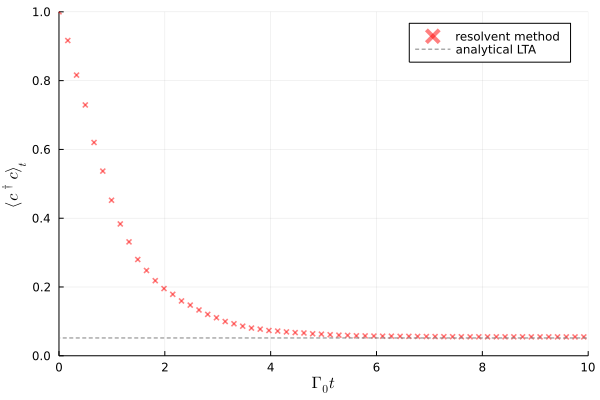

In [15]:
using Plots

plot(
    xlabel = "\$\\Gamma_0t\$", ylabel = "\$\\langle c^\\dagger c\\rangle_t\$",
    xlim = (0, gamma*T), ylim = (0, 1)
)

# plot spectral method result
plot!(gamma*times, record[:], lw=1.5, label="spectral method")

# plot resolvent result
scatter!(gamma*times_res, record_res, marker=:x, mc=:red, ms=2.5, msw=2, ma=0.5, label="resolvent method")

# plot LTA
hline!([LTA_occupation_1D(imp.Delta, imp.g, Ef)], color=:gray, ls=:dash, label="analytical LTA")

<!-- # <span style='background:lightgreen'> Bath dynamics in 1D</span> -->
## Bath dynamics in 1D

In [16]:
L = 2^8     # number of bath sites
Ef = 0.5    # Fermi level
imp = Impurity(Delta=1.5, g=0.4, x=(div(L, 2),))    # impurity coupled to middle of the bath
gamma = decay_rate(imp)    # single impurity decay rate
dt = 0.01                  # trotterisation time step
T = 9/gamma                # final time

# initial correlation matrix (occupied impurity + Fermi sea)
Cc = ones(ComplexF64, 1, 1)
Cb = diagm(ComplexF64[(2*(1 - cos(2*pi*k/L)) < Ef) for k in 0:(L - 1)])
Ccb = zeros(ComplexF64, 1, L)

# evolution of bath occupations
output(Cc, Cb, Ccb) = real(diag(Cb))
@time times, record = spectral_evolution!(output, Cc, Cb, Ccb, [imp], dt, ceil(Int, T/dt));

 10.511649 seconds (294.94 k allocations: 453.979 MiB, 0.68% gc time, 0.79% compilation time)


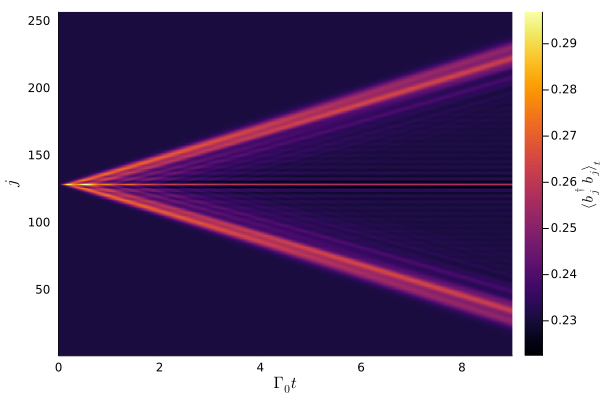

In [17]:
heatmap(gamma*times, 1:L, record',
    xlabel = "\$\\Gamma_0t\$", ylabel = "\$j\$",
    colorbar_title = "\$\\langle b_j^\\dagger b_j\\rangle_t\$"
)

<!-- # <span style='background:lightgreen'> Impurity occupation dynamics in 2D</span> -->
## Impurity occupation dynamics in 2D

In [6]:
?discretised_hamiltonian

search: discretised_hamiltonian



```
discretised_hamiltonian(impurity_list, L, Nbin, dispersion)
```

Construct the Hamiltonian of a set of impurities coupled to a D-dimensional bath with a  discretised energy band.

#### Arguments

  * `dispersion::Function`: bath dispersion relation [of the form `dispersion(k)`].
  * `impurity_list::Vector{Impurity{D}}`: list of impurities coupled to the bath.
  * `L::Int64`: linear bath size.
  * `Nbin::Int64`: number of frequency bins.


In [7]:
?hamiltonian_evolution!

search: hamiltonian_evolution!



```
times, record = hamiltonian_evolution!(output, C, H, dt, Nsteps)
```

Calculate the time-evolution of arbitrary quantities for an arbitrary quadratic Hamiltonian.

#### Arguments

  * `output::Function`: quantities of interest [of the form `output(C)`].
  * `C::Matrix{ComplexF64}`: initial correlation matrix (overwritten with the final  correlation matrix).
  * `H::Matrix{ComplexF64}`: single-particle Hamiltonian matrix.
  * `dt::Float64`: time step of the trotterised time-evolution.
  * `Nsteps::Int64`: number of time steps computed.

#### Outputs

  * `times::StepRangeLen`: range of times at which the quantities of interest are evaluated.
  * `record::Matrix{eltype(output(C))}`: record of outputs.


In [8]:
using Elliptic, LinearAlgebra

L = 2^9     # number of bath sites
Ef = 1.5    # Fermi level
imp = Impurity(Delta=1.5, g=0.4, x=(div(L, 2), div(L, 2)));    # impurity coupled to middle of the bath

decay_rate(imp) = imp.g^2/pi*K(1 - ((imp.Delta - 4)/4)^2)    # single-impurity decay rate
gamma = decay_rate(imp)
dt = 0.01                                                    # trotterisation time step
T = 10/gamma                                                 # final time

dispersion(k) = 2*(2 - cos(k[1]) - cos(k[2]))            # 2D bath dispersion relation
Nbin = L                                                 # number of bins
H = discretised_hamiltonian(dispersion, [imp], L, Nbin)  # discretised Hamiltonian

# Initial correlation matrix (occupied impurity + Fermi sea) of the impurities and relevant bath modes
Cc = ones(ComplexF64, 1, 1)
Cb = diagm(ComplexF64.(real(diag(H)[2:end]) .< Ef))
Ccb = zeros(ComplexF64, 1, Nbin)
C = [[Cc Ccb]; [Ccb' Cb]]

# evolution of impurity occupation (frequency discretisation method)
output(C) = [real(C[1, 1])]
@time times, record = hamiltonian_evolution!(output, C, H, dt, ceil(Int, T/dt));

 62.357687 seconds (50.17 k allocations: 78.613 GiB, 4.02% gc time, 0.01% compilation time)


In [9]:
# evolution of impurity occupation (resolvent method)
times_res = times[2:100:end]
@time record_res = occupation_2D(imp.Delta, imp.g, Ef, times_res);

610.635373 seconds (57.54 M allocations: 3.602 GiB, 0.23% gc time, 2.61% compilation time)


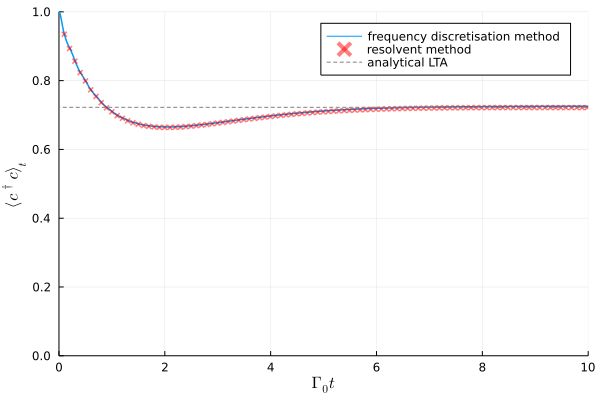

In [10]:
using Plots

plot(
    xlabel = "\$\\Gamma_0t\$", ylabel = "\$\\langle c^\\dagger c\\rangle_t\$",
    xlim = (0, gamma*T), ylim = (0,1),
)

# plot frequency discretisation result
plot!(gamma*times, record, lw=1.5, label="frequency discretisation method")

# plot resolvent result
scatter!(gamma*times_res, record_res, marker=:x, mc=:red, ms=2.5, msw=2, ma=0.5, label="resolvent method")

# plot LTA
hline!([LTA_occupation_2D(imp.Delta, imp.g, Ef)], color=:gray, ls=:dash, label="analytical LTA")